In [1]:
import tensorflow as tf
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.engine.functional import Functional
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.regularizers import l2
import os
import scipy

### Import the MNIST data class and call it.

(28, 28, 1)


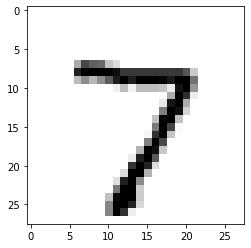

In [2]:
import MNIST_dataset as mnist
data = mnist.MNISTData()
print(data.x_train[0].shape)
plt.imshow(data.x_test[0], cmap='gray_r')

In [3]:
zoom_factor = 0.5
data_zoom = mnist.MNISTData(data_fraction=0.001, zoom_factor=zoom_factor)

#x_train= data_zoom.x_test
#print(x_train.shape)
"""x_train =  scipy.ndimage.zoom(x_train, (1, zoom_factor, zoom_factor, 1))
print(x_train.shape)

shape_train = x_train.shape[1]*x_train.shape[2]*x_train.shape[0]
print(shape_train)
x_train = x_train.reshape([shape_train,])
print(x_train[0].shape)"""
#print(data_zoom.x_train[0].shape)
#plt.imshow(data_zoom.x_test[0].reshape(14,14), cmap='gray_r')

#x_test =  scipy.ndimage.zoom(x_test, (1, zoom_factor, zoom_factor, 1))
#print(x_test.shape)
#shape = int(x_test.shape[1]* x_test.shape[2])
#print(shape)
#x_test = x_test.reshape([shape,])
#print(x_test.shape)
#plt.imshow(data_zoom.x_test[0].reshape(14,14), cmap='gray_r')


'x_train =  scipy.ndimage.zoom(x_train, (1, zoom_factor, zoom_factor, 1))\nprint(x_train.shape)\n\nshape_train = x_train.shape[1]*x_train.shape[2]*x_train.shape[0]\nprint(shape_train)\nx_train = x_train.reshape([shape_train,])\nprint(x_train[0].shape)'

# Autoencoder using Keras
The aim of this class is to implement a simple autoencoder for the MNIST data and then build an autoencoder that is
able to classify MNIST data in its latent dimension.

Code partially adapted from [Keras Documentation](https://blog.keras.io/building-autoencoders-in-keras.html).

In [23]:
class Autoencoder:
    """Autoencoder Class"""

    def __init__(self, data: mnist.MNISTData, num_classes=10):
        self.x_train = data.x_train
        self.x_test = data.x_test
        self.y_train = data.y_train
        self.y_test = data.y_test

        self.num_classes = num_classes
        self.input_shape = self.x_train[0].shape
        self.input = Input(shape=self.input_shape, name='encoder_input')

        self.encoder = None
        self.encoder_model = None
        self.decoder = None
        self.latent_classifier = None
        self.autoencoder = None

        self.history = None

    def build_encoder(self):
        """Build your encoder architecture and store the output in self.encoder. 
        The final encoding dimension is 2."""
        self.encoder = Dense(49,  activation='relu')(self.input)
        self.encoder = Dense(7,  activation='relu')(self.encoder)
        self.encoder = Dense(2,  activation='relu', name = 'encoder_output')(self.encoder)      
        
        #building a model for the encoder in order to be able to predict and plot the latent dimension
        self.encoder_model = Model(self.input, self.encoder, name='encoder')

    def build_decoder(self):
        """Build the decoder architecture."""
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the decoder!")
        self.decoder = Dense(7, activation='relu')(self.encoder)
        self.decoder = Dense(49, activation='relu')(self.decoder)
        self.decoder = Dense(196,activation='sigmoid', name='ecoder_output')(self.decoder)

    def build_classifier(self):
        """ Building the classifier architecture."""
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the classifier!")
        self.latent_classifier = Dense(128, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(self.encoder)
        self.latent_classifier = Dense(64, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(self.latent_classifier)
        self.latent_classifier = Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(self.latent_classifier)

        self.latent_classifier = Dense(self.num_classes, activation='softmax',name='classifier_output')(self.latent_classifier)

    def build_autoencoder(self, use_latent_classifier=False):
        """ Build the whole autoencoder Model from self.encoder and self.decoder."""
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the autoencoder!")
        if self.decoder is None:
            raise RuntimeError("The decoder has to be built before you can build the autoencoder!")

        if use_latent_classifier:
            if self.latent_classifier is None:
                raise RuntimeError("If you want to use the option with the latent classifier, you have to build it "
                                   "beforehand!")
            self.autoencoder = Model(self.input, outputs=[self.decoder, self.latent_classifier])
            self.autoencoder.compile(loss=['mse', 'categorical_crossentropy'], loss_weights=[1, 0.1], optimizer='adam',
                                     metrics="accuracy")
        else:
            self.autoencoder = Model(self.input, outputs=self.decoder, name = 'autoencoder')
            self.autoencoder.compile(loss='mse', optimizer='adam') 
            self.autoencoder.save('model_1/KERAS_check_best_model.h5')
        self.autoencoder.summary()

    def fit_data(self, batch_size=256, epochs=40, use_latent_classifier=False):
        """Write the fit function for the autoencoder. 
        Storing the fit history in self.history to be able to plot the fitting scores."""
        if use_latent_classifier:
            self.history = self.autoencoder.fit(self.x_train, [self.x_train, self.y_train],
                                                validation_data=(self.x_test, [self.x_test, self.y_test]),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True,
                                                )
        else:
        
                              
            self.history = self.autoencoder.fit(self.x_train, self.x_train,
                                                validation_data=(self.x_test, self.x_test),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True
                                                )

        self.history = self.history.history

    def dir(self):
        """Creation of the folders path to store the results."""
        dir = os.path.join("images")
        if not os.path.exists(dir):
            os.mkdir(dir)
        dir2 = os.path.join("./images/AE")
        if not os.path.exists(dir2):
            os.mkdir(dir2)
    
    def plot_score(self, model_name=None):
        """Plots the scores achieved during the fitting."""
        plt.plot(self.history['loss'])
        plt.plot(self.history['val_loss'])
        plt.ylabel('Model Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='best')
        plt.title('Accuracy of {model_name}'.format(model_name=model_name))
        
        plt.savefig('./images/AE/Accuracy of {model_name}.png'.format(model_name=model_name))
        
        plt.show()

    def plot_latent_dimension(self, model_name = None):
        """Plots the latent dimension of the autoencoder."""
        prediction = self.encoder_model.predict(self.x_test)
        fig = plt.figure(figsize=(10, 10))
        fig.patch.set_facecolor("white")
        plt.scatter(prediction[:, 0], prediction[:, 1], c=np.argmax(self.y_test, axis=1), cmap="Set3")
        plt.colorbar()
        plt.title('Latent space {model_name}'.format(model_name=model_name))


        plt.savefig('./images/AE/Latent dimension of {model_name}.png'.format(model_name=model_name))

        plt.show()

    def plot_reco(self, use_latent_classifier = False):
        """Plotting reconstructed images"""
        
        n = 6
        plt.figure(figsize=(10, 3))
        reco_imgs = self.autoencoder.predict(self.x_test)
        
        if use_latent_classifier :
            raise RuntimeError("You are considering the autoencoder with classifier!")
        else:
        
            for i in range(n):
                # Display original MNIST
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(self.x_test[i].reshape(28,28), cmap='gray_r')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                # Display reconstructed MNIST            
                ax = plt.subplot(2, n, i + n + 1)
                plt.imshow(reco_imgs[i].reshape(28,28), cmap='gray_r')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            plt.savefig('./images/AE/reconstructed images.png')
            plt.show()
 


It is built the standard autoencoder, *without classifier* here, and the MNIST data class called before is used. 
The model is fitted and adequate plots are reproduced, 
as well as the comparison between orginal MNIST dataset and reconstructed images.

In [24]:
network = Autoencoder(data)
network.build_encoder()
network.build_decoder()
network.build_autoencoder()
network.dir()
network.fit_data(epochs=10)
network.plot_latent_dimension("Autoencoder without classifier")
network.plot_reco()
network.plot_score("Autoencoder without classifier")


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
dense (Dense)                (None, 28, 28, 49)        98        
_________________________________________________________________
dense_1 (Dense)              (None, 28, 28, 7)         350       
_________________________________________________________________
encoder_output (Dense)       (None, 28, 28, 2)         16        
_________________________________________________________________
dense_2 (Dense)              (None, 28, 28, 7)         21        
_________________________________________________________________
dense_3 (Dense)              (None, 28, 28, 49)        392       
_________________________________________________________________
ecoder_output (Dense)        (None, 28, 28, 196)       

KeyboardInterrupt: 

# Make an hls4ml config & model

In [6]:
import plotting
import hls4ml
config = hls4ml.utils.config_from_keras_model(network.autoencoder, granularity='model')
print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(network.autoencoder,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e')


Interpreting Model
Topology:
Layer name: encoder_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: encoder_output, layer type: Dense
  -> Activation (relu), layer name: encoder_output
Layer name: dense_2, layer type: Dense
  -> Activation (relu), layer name: dense_2
Layer name: dense_3, layer type: Dense
  -> Activation (relu), layer name: dense_3
Layer name: ecoder_output, layer type: Dense
  -> Activation (sigmoid), layer name: ecoder_output
-----------------------------------
Configuration
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
-----------------------------------
Interpreting Model
Topology:
Layer name: encoder_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: dense, layer type: Dense, input shapes: [[None, 784]], output shape: [None, 128]
Layer

C:\Users\loren\miniconda3\envs\MLinPhysics\lib\site-packages\hls4ml\converters\__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [10]:
hls_model.build()
hls4ml.report.read_vivado_report('my-hls-test')


Project myproject_prj does not exist. Rerun "hls4ml build -p model_1/hls4ml_prj".
Path my-hls-test does not exist. Exiting.


# Compile, predict

In [9]:
hls_model.compile()
data.x_test = np.ascontiguousarray(data.x_test)
y_hls = hls_model.predict(data.x_test)

Writing HLS project
Done


FileNotFoundError: Could not find module 'c:\Users\loren\Desktop\CODE\Electronics Project\DL-model-for-FPGA\model_1\hls4ml_prj\firmware\myproject-Ee3D4600.so' (or one of its dependencies). Try using the full path with constructor syntax.